# Create DataBase

##### Scraping Mp3's with python library, youtube_dl
##### -Storing them in genre specific directories.

```python
from __future__ import unicode_literals
import youtube_dl

genres = {'country': 'https://www.youtube.com/watch?v=zXDAYlhdkyg&list=PL3oW2tjiIxvQW6c-4Iry8Bpp3QId40S5S', 
          'jazz': 'https://www.youtube.com/watch?v=RPfFhfSuUZ4&list=PL8F6B0753B2CCA128', 
          'hip_hop': 'https://www.youtube.com/playlist?list=PLAPo1R_GVX4IZGbDvUH60bOwIOnZplZzM', 
          'classical': 'https://www.youtube.com/watch?v=kSE15tLBdso&list=PLRb-5mC4V_Lop8KLXqSqMv4_mqw5M9jjW', 
          'metal': 'https://www.youtube.com/playlist?list=PLfY-m4YMsF-OM1zG80pMguej_Ufm8t0VC', 
          'electronic': 'https://www.youtube.com/watch?v=pvuN_WvF1to&list=PLDDAxmBan0BKeIxuYWjMPBWGXDqNRaW5S'
 }

for genre, playlist in genres.items():
    
    path = 'songs/' + genre + '/%(title)s.%(ext)s'
    
    ydl_opts = {
        'format': 'bestaudio/best',
        'ignoreerrors': True,
        'playlistend': 110,
        'nooverwrites': True,
        'outtmpl': path,
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'mp3',
            'preferredquality': '192',
        }],
    }

    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        ydl.download([playlist])```

##### Processing Mp3s with python library, librosa
##### -Storing audio features in a csv

```python
import csv
import os
import librosa
import numpy as np

header = 'name tempo beats chroma_stft rmse spec_cent spec_bw rolloff zcr'.split()
header += ['mfcc_' + str(i) for i in range(1,12)] + ['label']
file = open('data.csv', 'w', newline='')

with file:
    writer = csv.writer(file)
    writer.writerow(header)
    genres = ['country', 'jazz', 'metal', 'hip_hop', 'electronic', 'classical']

for genre in genres:
    for filename in os.listdir('./songs/' + genre):
        if filename.endswith('.mp3'):
            songname = f'./songs/{genre}/{filename}'
            y, sr = librosa.load(songname, mono=True, duration=180, sr=None)
            tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            rmse = librosa.feature.rmse(y=y)
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12)
            label = genre.title()

            to_append = f'{tempo}, {beats.shape[0]}, {np.mean(chroma_stft)}, {np.mean(rmse)},'
            to_append += f'{np.mean(spec_cent)}, {np.mean(spec_bw)}, {np.mean(rolloff)}, {np.mean(zcr)}'    

            for e in mfcc[1:]:
                to_append += f',{np.mean(e)}'

            to_append += f',{label}'
            file = open('data.csv', 'a', newline='')

            with file:
                writer = csv.writer(file)
                song_row = [filename] + to_append.split(',')
                writer.writerow(song_row)
                ```

# Explore Data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
plt.style.use('ggplot')

In [4]:
df = pd.read_csv('data_3k.csv')
print(df.shape)
df.head(3)

(3822, 21)


,name,tempo,beats,chroma_stft,rmse,spec_cent,spec_bw,rolloff,zcr,mfcc_1,...,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,label
0,Aaron Lewis - 'Country Boy' (Official Video).m...,125.000000,59,0.409949,0.044608,2684.678379,3327.070199,5616.759798,0.054827,150.374682,...,41.741827,-12.544442,28.144194,-13.241323,17.689333,-4.589490,3.226390,-4.043833,4.592962,Country
1,Aaron Lewis - 'Country Boy' (Official Video).m...,119.680851,58,0.431026,0.053247,2512.620073,3235.770491,4958.476826,0.053470,162.977125,...,29.105995,-7.695438,26.248572,-13.276758,15.348517,1.977714,0.815487,-3.722481,5.629056,Country
2,Aaron Lewis - 'Country Boy' (Official Video).m...,122.282609,59,0.412145,0.068782,2998.444102,3466.782972,6078.969294,0.068072,152.629035,...,36.643452,-11.062471,28.772055,-18.319343,11.178653,-6.798670,2.469059,-1.228891,10.052697,Country


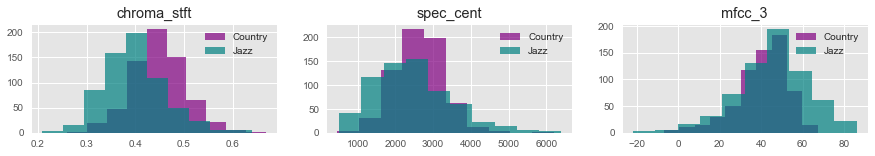

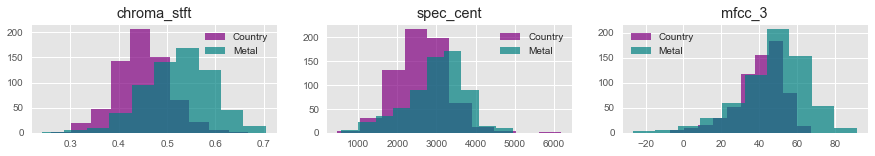

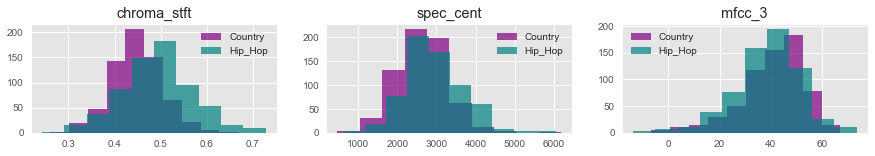

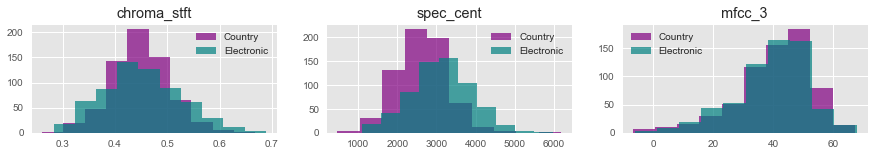

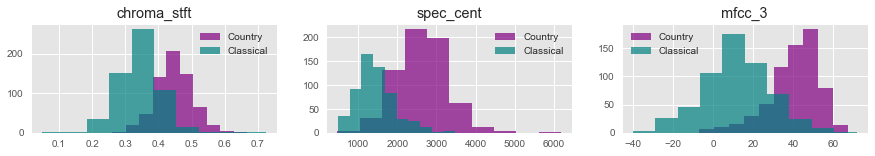

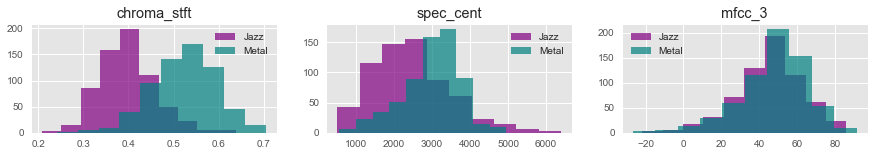

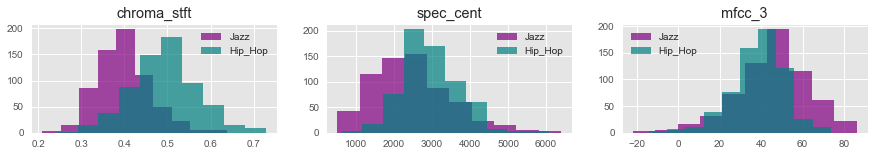

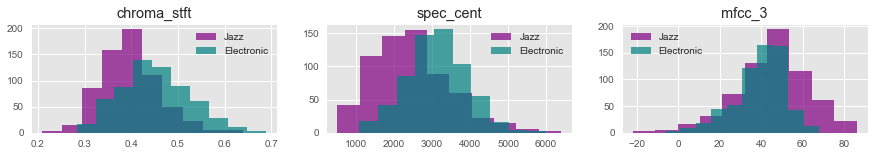

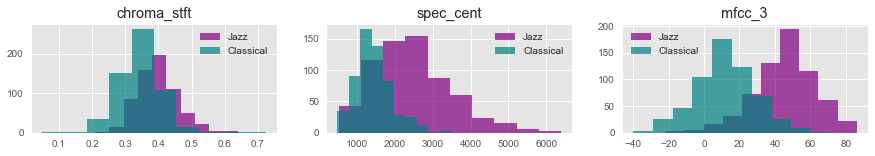

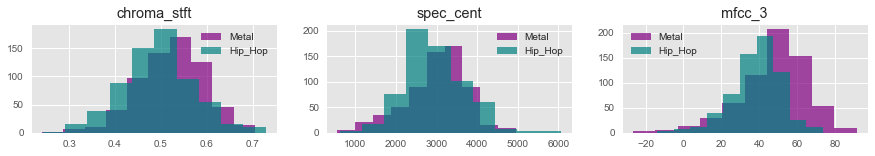

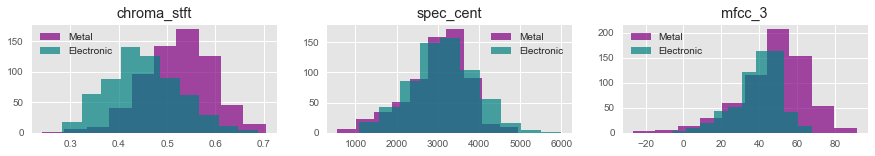

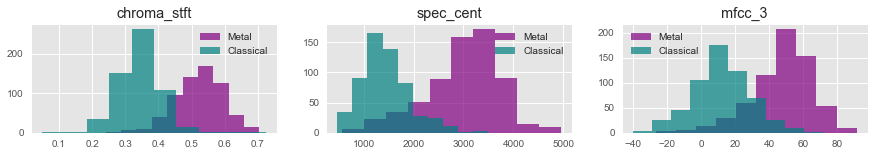

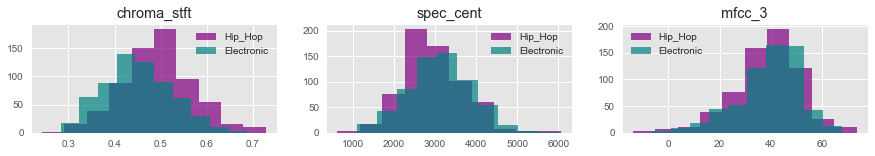

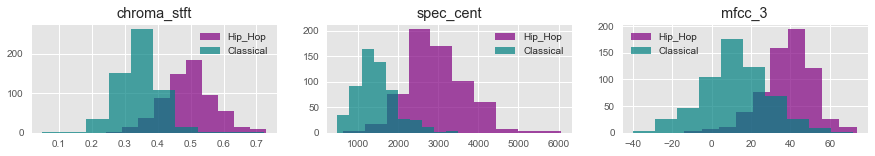

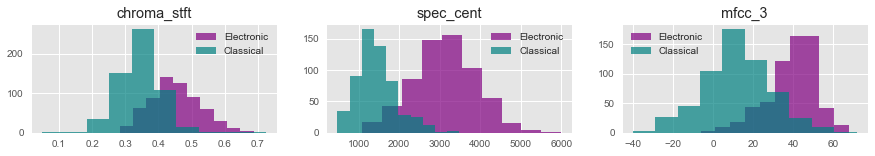

In [41]:
col_1 = 'chroma_stft'
col_2 = 'spec_cent'
col_3 = 'mfcc_3'
cols = [col_1, col_2, col_3]
for g1, g2 in itertools.combinations(df.label.unique(), 2):
    plt.figure(figsize=(15,2))
    for i, col in enumerate(cols):
        plt.subplot(1,3,i+1)
        plt.hist(df.loc[df.label == g1, col], alpha=0.7, label=g1, color='purple')
        plt.hist(df.loc[df.label == g2, col], alpha=0.7, label=g2, color='teal')
        plt.title(col)
        plt.legend()
    plt.show()

# Explore Models

### Bootstrap Aggregating Trees

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, hamming_loss, jaccard_similarity_score
plt.style.use('default')

In [8]:
X = df.drop(['name', 'label'],  axis=1).astype(float)
genre_map = {g:i for i, g in enumerate(df.label.unique())}
y = df.label#.map(genre_map)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [34]:
bag_clf = BaggingClassifier(n_jobs=-1)
bag_clf.fit(X_train, y_train)
bag_preds = bag_clf.predict(X_test)

{'Country': 0, 'Jazz': 1, 'Metal': 2, 'Hip_Hop': 3, 'Electronic': 4, 'Classical': 5}
[[108   4   0   1   4   0]
 [  7 104  15  11   8   5]
 [  2  13  89  23   2   6]
 [  0  10  20  79   1   5]
 [ 14   4   3   4 104   4]
 [  6  16   8  10   5  70]]


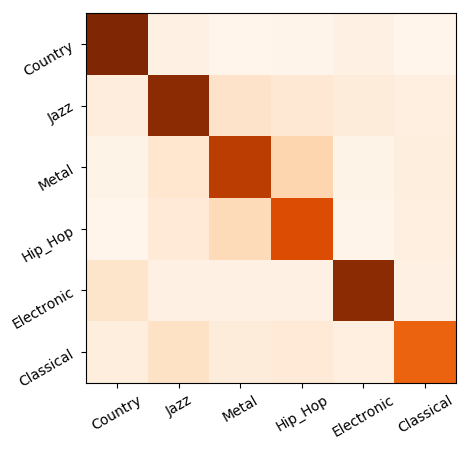

In [53]:
bag_cm = confusion_matrix(y_test, bag_preds)
tick_labels=['Country', 'Jazz', 'Metal', 'Hip_Hop', 'Electronic', 'Classical']

plt.imshow(bag_cm, cmap='Oranges')
plt.xticks(np.arange(6),labels=tick_labels, rotation=30)
plt.yticks(np.arange(6),labels=tick_labels, rotation=30)

print(genre_map)
print(bag_cm)

In [77]:
print(f'hamming: {hamming_loss(y_test, bag_preds)},'
      f' jacc: {jaccard_similarity_score(y_test, bag_preds)}')

hamming: 0.2758169934640523, jacc: 0.7241830065359477


### Gradient Boosted Trees

In [52]:
from sklearn.ensemble import GradientBoostingClassifier

gbt_clf = GradientBoostingClassifier()
gbt_clf.fit(X_train, y_train)
gbt_preds = gbt_clf.predict(X_test)

{'Country': 0, 'Jazz': 1, 'Metal': 2, 'Hip_Hop': 3, 'Electronic': 4, 'Classical': 5}
[[109   1   0   3   4   0]
 [  2 118  10  10   5   5]
 [  0  13  94  20   4   4]
 [  0  10  13  81   5   6]
 [ 13   6   0   4 106   4]
 [  5  18   6   7   3  76]]


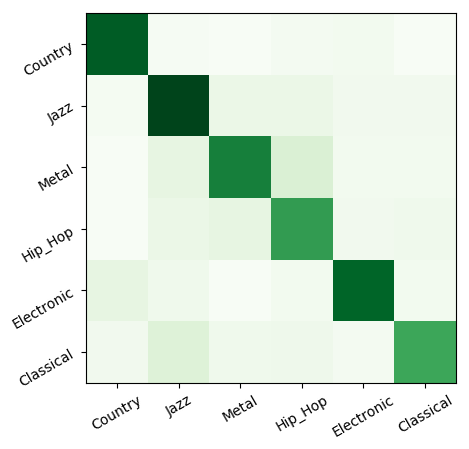

In [57]:
gbt_cm = confusion_matrix(y_test, gbt_preds)
tick_labels=['Country', 'Jazz', 'Metal', 'Hip_Hop', 'Electronic', 'Classical']

plt.imshow(gbt_cm, cmap='Greens')
plt.xticks(np.arange(6),labels=tick_labels, rotation=30)
plt.yticks(np.arange(6),labels=tick_labels, rotation=30)

print(genre_map)
print(gbt_cm)

In [78]:
print(f'hamming: {hamming_loss(y_test, gbt_preds)},'
      f' jacc: {jaccard_similarity_score(y_test, gbt_preds)}')

hamming: 0.23660130718954248, jacc: 0.7633986928104575


### Logistic Regression Classifier

In [10]:
# We'll want to scale for non tree classifiers
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler=StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [70]:
logreg_clf = LogisticRegression(solver='lbfgs',multi_class='multinomial', n_jobs=-1)
logreg_clf.fit(X_train_scaled, y_train)
logreg_preds = logreg_clf.predict(X_test_scaled)

{'Country': 0, 'Jazz': 1, 'Metal': 2, 'Hip_Hop': 3, 'Electronic': 4, 'Classical': 5}
[[106   7   1   0   3   0]
 [  2 100  13  12   9  14]
 [  0   8  89  28   6   4]
 [  1   8  24  70   3   9]
 [ 15  13   4   4  92   5]
 [  6  12   5   4   6  82]]


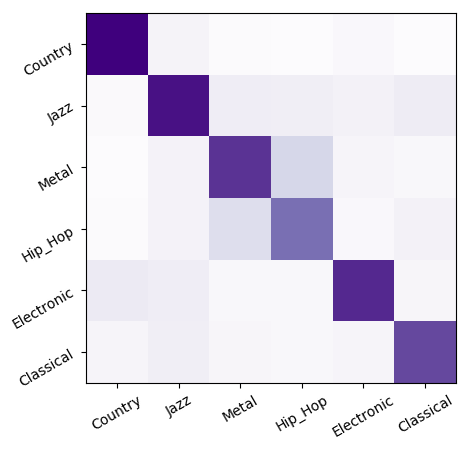

In [71]:
logreg_cm = confusion_matrix(y_test, logreg_preds)
tick_labels=['Country', 'Jazz', 'Metal', 'Hip_Hop', 'Electronic', 'Classical']

plt.imshow(logreg_cm, cmap='Purples')
plt.xticks(np.arange(6),labels=tick_labels, rotation=30)
plt.yticks(np.arange(6),labels=tick_labels, rotation=30)

print(genre_map)
print(logreg_cm)

In [79]:
print(f'hamming: {hamming_loss(y_test, logreg_preds)},'
      f'jacc: {jaccard_similarity_score(y_test, logreg_preds)}')

hamming: 0.2954248366013072,jacc: 0.7045751633986929


### Support Vector Machine

In [11]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train_scaled, y_train)
svc_preds = svc.predict(X_test_scaled)

{'Country': 0, 'Jazz': 1, 'Metal': 2, 'Hip_Hop': 3, 'Electronic': 4, 'Classical': 5}
[[110   3   0   1   2   1]
 [  3 115   9  12   4   7]
 [  1   8  95  19   6   6]
 [  1  10  17  80   2   5]
 [ 15   8   0   1 107   2]
 [  5  14   2   6   3  85]]


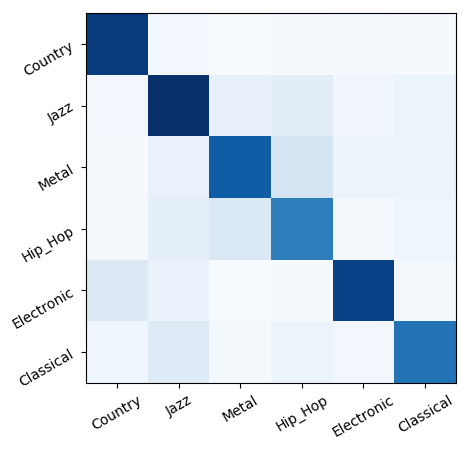

In [12]:
svc_cm = confusion_matrix(y_test, svc_preds)
tick_labels=['Country', 'Jazz', 'Metal', 'Hip_Hop', 'Electronic', 'Classical']

plt.imshow(svc_cm, cmap='Blues')
plt.xticks(np.arange(6),labels=tick_labels, rotation=30)
plt.yticks(np.arange(6),labels=tick_labels, rotation=30)

print(genre_map)
print(svc_cm)

In [13]:
print(f'hamming: {hamming_loss(y_test, svc_preds)},'
      f'jacc: {jaccard_similarity_score(y_test, svc_preds)}')

hamming: 0.2261437908496732,jacc: 0.7738562091503268


# Grid Search

In [94]:
# It looks like Gradient Boosted Trees and Support Vector Machine Models Perform Best
from sklearn.model_selection import GridSearchCV

gbt_param_grid = {
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [2, 3, 4],
    'n_estimators': [100, 150, 175]
}
gbt_grid = GridSearchCV(estimator=gbt_clf, param_grid=gbt_param_grid,
                       iid=False, cv=5, return_train_score=True, n_jobs=-1)

In [105]:
# gbt_grid.fit(X_train, y_train)     # Commented out for long run time

In [96]:
gbt_grid.best_params_

{'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 175}

In [100]:
gbt_param_grid = {
    'learning_rate': [0.15, 0.2, 0.25],
    'max_depth': [4, 5, 6],
    'n_estimators': [175, 200, 250]
}
gbt_grid = GridSearchCV(estimator=gbt_clf, param_grid=gbt_param_grid,
                       iid=False, cv=5, return_train_score=True, n_jobs=-1)

In [104]:
# gbt_grid.fit(X_train, y_train)     # Commented out for long run time

In [103]:
gbt_grid.best_params_

{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 175}

In [106]:
gbt_grid_preds = gbt_grid.predict(X_test)
print(f'hamming: {hamming_loss(y_test, gbt_grid_preds)},'
      f'jacc: {jaccard_similarity_score(y_test, gbt_grid_preds)}')

hamming: 0.21568627450980393,jacc: 0.7843137254901961


In [107]:
# What about our SVM Classifier?

svc_param_grid = {
    'C': [0.5, 1, 5, 10,20,50,100,],
    'decision_function_shape': ['ovo', 'ovr'],
    'gamma': ['scale', 'auto']

}
svc_grid = GridSearchCV(estimator=svc, param_grid=svc_param_grid,
                       iid=False, cv=5, return_train_score=True, n_jobs=-1)

In [113]:
# svc_grid.fit(X_train_scaled, y_train)

In [110]:
svc_grid.best_params_

{'C': 10, 'decision_function_shape': 'ovo', 'gamma': 'scale'}

In [112]:
svc_grid_preds = svc_grid.predict(X_test_scaled)
print(f'hamming: {hamming_loss(y_test, svc_grid_preds)},'
      f'jacc: {jaccard_similarity_score(y_test, svc_grid_preds)}')

hamming: 0.18562091503267975,jacc: 0.8143790849673203


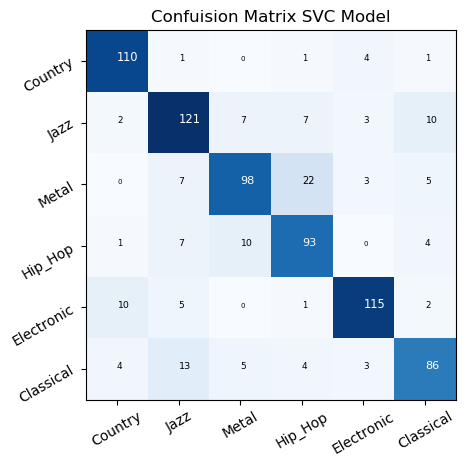

In [136]:
svc_grid_cm = confusion_matrix(y_test, svc_grid_preds)
tick_labels=['Country', 'Jazz', 'Metal', 'Hip_Hop', 'Electronic', 'Classical']

plt.title('Confuision Matrix SVC Model')
plt.imshow(svc_grid_cm, cmap='Blues')
plt.xticks(np.arange(6),labels=tick_labels, rotation=30)
plt.yticks(np.arange(6),labels=tick_labels, rotation=30)

thresh = svc_grid_cm.max()/2
for i,j in itertools.product(range(6),range(6)):
    val = svc_grid_cm[i,j]
    plt.text(j,i, val, 
                color='white' if val>thresh else 'black',
                size=val**0.25+5)

# Lets Try To Predict A Song!

In [20]:
from SongClassifier import SongClassifier

/Applications/anaconda3/envs/learn-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Applications/anaconda3/envs/learn-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [21]:
guess = SongClassifier()

In [22]:
guess.predict('https://youtu.be/7ysFgElQtjI')

[youtube] 7ysFgElQtjI: Downloading webpage
[youtube] 7ysFgElQtjI: Downloading video info webpage
[youtube] 7ysFgElQtjI: Downloading js player vfl5VAqDi
[download] Destination: mystery_song.webm
[download] 100% of 2.72MiB in 00:00
[ffmpeg] Destination: mystery_song.mp3
Deleting original file mystery_song.webm (pass -k to keep)
-----------------------
Probability of Genre:
-----------------------
Country : 1.54%
Jazz : 1.72%
Metal : 6.79%
Hip_Hop : 74.21%
Electronic : 12.35%
Classical : 3.39%


In [1]:
from sklearn.metrics import f1_score